In [1]:
!pip install -q -U autogluon.tabular ray

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.13.0 requires aiohttp<4.0.0,>=3.9.2, which is not installed.
s3fs 2024.3.1 requires aiohttp!=4.0.0a0,!=4.0.0a1, which is not installed.
aiobotocore 2.13.0 requires botocore<1.34.107,>=1.34.70, but you have botocore 1.29.165 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


# Imports and Configs

In [2]:
from autogluon.tabular import TabularPredictor, TabularDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import shutil
import pickle
import glob
import os

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_palette('husl')

In [3]:
TIME_LIMIT = 3600 * 9
N_FOLDS = 5
SEED = 27
TARGET = 'Target'

# Loading and Processing the Datasets

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv', index_col='id')

train.shape, test.shape

((76518, 37), (51012, 36))

In [5]:
cat_features = [
    'Marital status',
    'Application mode',
    'Course',
    'Previous qualification',
    'Nacionality',
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation"
]

for feature in cat_features:
    train[feature] = train[feature].astype('category')
    test[feature] = test[feature].astype('category')

In [6]:
train = TabularDataset(train)
test = TabularDataset(test)

# Setting up K-Fold CV and Training

In [7]:
os.mkdir('test_preds')
os.mkdir('test_pred_probs')

In [8]:
skf = StratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)

histories = {}
oof_pred_probs = np.zeros((len(train), train[TARGET].nunique()))
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(train.drop(columns=TARGET), train[TARGET])):
    _train, _val = train.iloc[train_idx], train.iloc[val_idx]    

    predictor = TabularPredictor(
        label=TARGET,
        eval_metric='accuracy',
        problem_type='multiclass',
        verbosity=2
    ).fit(
        train_data=_train,
        time_limit=TIME_LIMIT // N_FOLDS,
        excluded_model_types = ['KNN'],
        presets='best_quality',
        save_space=True,
        ag_args_fit = {
            "stopping_metric": "log_loss",
        }
    )
    
    fold_score = predictor.evaluate(_val, silent=True)['accuracy']
    
    pred_probs = predictor.predict_proba(_val)
    preds = pred_probs.idxmax(axis=1).values
    oof_pred_probs[val_idx] = pred_probs
    
    test_pred_probs = predictor.predict_proba(test)
    
    test_preds = test_pred_probs.idxmax(axis=1).values
    test_preds = pd.DataFrame({TARGET: test_preds}, index=test.index)
    test_preds.to_csv(f'test_preds/fold_{fold_idx}_test_preds_acc-{fold_score:.6f}.csv')
    
    test_pred_probs = pd.DataFrame(test_pred_probs, index=test.index)
    test_pred_probs.to_csv(f'test_pred_probs/fold_{fold_idx}_test_pred_probs_acc-{fold_score:.6f}.csv')
    
    histories[f'Fold {fold_idx}'] = {}
    histories[f'Fold {fold_idx}']['y'] = _val[TARGET].values
    histories[f'Fold {fold_idx}']['pred_probs'] = pred_probs
    histories[f'Fold {fold_idx}']['preds'] = preds
    histories[f'Fold {fold_idx}']['accuracy'] = fold_score
    histories[f'Fold {fold_idx}']['auc'] = roc_auc_score(_val[TARGET], pred_probs, multi_class='ovo')
    histories[f'Fold {fold_idx}']['leaderboard'] = predictor.leaderboard(_val, silent=True)
    histories[f'Fold {fold_idx}']['feature_importance'] = predictor.feature_importance(_val, silent=True)
    
    print(f'Fold {fold_idx} - Accuracy: {fold_score}')
    
    shutil.rmtree("AutogluonModels")
    del predictor

No path specified. Models will be saved in: "AutogluonModels/ag-20240609_084033"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 6480 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240609_084033/ds_sub_fit/sub_fit_ho.
2024-06-09 08:40:34,381	INFO util.py:124 -- Outdated packages:
  ipywidgets==7

Fold 0 - Accuracy: 0.8357292211186618


No path specified. Models will be saved in: "AutogluonModels/ag-20240609_105142"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 6480 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240609_105142/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 1620s
AutoGluon will save models

Fold 1 - Accuracy: 0.8348144276006273


No path specified. Models will be saved in: "AutogluonModels/ag-20240609_125959"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 6480 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240609_125959/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 1620s
AutoGluon will save models

Fold 2 - Accuracy: 0.8350757971772086


No path specified. Models will be saved in: "AutogluonModels/ag-20240609_151900"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 6480 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240609_151900/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 1620s
AutoGluon will save models

Fold 3 - Accuracy: 0.8339541266418349


No path specified. Models will be saved in: "AutogluonModels/ag-20240609_172246"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 6480 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240609_172246/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 1620s
AutoGluon will save models

Fold 4 - Accuracy: 0.8274194602365549


In [9]:
with open('ag_oof_pred_probs.pkl', 'wb') as f:
    pickle.dump(oof_pred_probs, f)

In [10]:
mappings = {v: k for k, v in enumerate(histories['Fold 0']['pred_probs'].columns)}
reverse_mappings = {v: k for k, v in mappings.items()}

In [11]:
histories['All'] = {}
histories['All']['accuracy'] = accuracy_score(train[TARGET].map(mappings), oof_pred_probs.argmax(axis=1))
histories['All']['auc'] = roc_auc_score(train[TARGET], oof_pred_probs, multi_class='ovo')
histories['All']['pred_probs'] = oof_pred_probs
histories['All']['preds'] = oof_pred_probs.argmax(axis=1)
histories['All']['y'] = train[TARGET].values

# Visualizing the Results

In [12]:
histories['Fold 0']['leaderboard'].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM_BAG_L1,0.837167,0.831133,accuracy,5.934784,2.852835,67.083899,5.934784,2.852835,67.083899,1,True,3
1,WeightedEnsemble_L2,0.835729,0.832718,accuracy,22.954762,15.834966,4246.434974,0.006691,0.006465,1.381541,2,True,10
2,CatBoost_BAG_L1,0.835599,0.830872,accuracy,0.617452,0.393641,3922.956593,0.617452,0.393641,3922.956593,1,True,6
3,XGBoost_BAG_L1,0.835403,0.831558,accuracy,3.545917,1.676525,130.622078,3.545917,1.676525,130.622078,1,True,9
4,LightGBMXT_BAG_L1,0.834226,0.830235,accuracy,10.464475,4.990391,101.823536,10.464475,4.990391,101.823536,1,True,2
5,RandomForestEntr_BAG_L1,0.829848,0.824223,accuracy,0.998704,2.761330,15.014727,0.998704,2.761330,15.014727,1,True,5
6,RandomForestGini_BAG_L1,0.829718,0.825154,accuracy,1.023952,2.885065,13.703933,1.023952,2.885065,13.703933,1,True,4
7,NeuralNetFastAI_BAG_L1,0.829456,0.825154,accuracy,2.454033,1.201119,533.935998,2.454033,1.201119,533.935998,1,True,1
8,ExtraTreesGini_BAG_L1,0.827039,0.822296,accuracy,1.361491,3.030043,8.863395,1.361491,3.030043,8.863395,1,True,7
9,ExtraTreesEntr_BAG_L1,0.825340,0.822573,accuracy,1.369924,3.096839,8.868084,1.369924,3.096839,8.868084,1,True,8


In [13]:
histories['Fold 1']['leaderboard'].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,XGBoost_BAG_L1,0.836709,0.829925,accuracy,3.934972,1.737896,136.187560,3.934972,1.737896,136.187560,1,True,9
1,LightGBM_BAG_L1,0.836187,0.830398,accuracy,4.614211,2.275487,60.245368,4.614211,2.275487,60.245368,1,True,3
2,WeightedEnsemble_L2,0.834814,0.832457,accuracy,19.663155,11.706370,4272.002319,0.006076,0.006293,1.352836,2,True,10
3,LightGBMXT_BAG_L1,0.834684,0.829794,accuracy,9.118801,4.301257,88.752172,9.118801,4.301257,88.752172,1,True,2
4,CatBoost_BAG_L1,0.834488,0.831035,accuracy,0.623726,0.390404,3976.611627,0.623726,0.390404,3976.611627,1,True,6
5,RandomForestGini_BAG_L1,0.830698,0.823798,accuracy,1.063820,2.776816,13.878829,1.063820,2.776816,13.878829,1,True,4
6,NeuralNetFastAI_BAG_L1,0.829652,0.823341,accuracy,2.511072,1.189523,503.432336,2.511072,1.189523,503.432336,1,True,1
7,RandomForestEntr_BAG_L1,0.829130,0.824207,accuracy,1.012947,2.672991,14.238722,1.012947,2.672991,14.238722,1,True,5
8,ExtraTreesGini_BAG_L1,0.825144,0.821544,accuracy,1.396803,3.035293,8.974369,1.396803,3.035293,8.974369,1,True,7
9,ExtraTreesEntr_BAG_L1,0.824686,0.822475,accuracy,1.365371,2.995033,8.852757,1.365371,2.995033,8.852757,1,True,8


In [14]:
histories['Fold 2']['leaderboard'].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.835076,0.832571,accuracy,33.624161,39.267559,4720.699930,0.010727,0.007277,2.545609,3,True,19
1,NeuralNetFastAI_BAG_L2,0.834880,0.829778,accuracy,27.557935,23.644677,3734.082481,2.763172,1.245618,537.237240,2,True,11
2,WeightedEnsemble_L2,0.834618,0.832424,accuracy,19.852385,15.028840,2703.907137,0.006971,0.006399,1.367923,2,True,10
3,CatBoost_BAG_L2,0.834618,0.831787,accuracy,24.994977,22.654204,4013.440400,0.200214,0.255145,816.595158,2,True,16
4,ExtraTreesGini_BAG_L2,0.834618,0.830268,accuracy,25.948330,26.275916,3206.464618,1.153567,3.876857,9.619376,2,True,17
5,ExtraTreesEntr_BAG_L2,0.833900,0.829778,accuracy,25.967616,26.148603,3206.803153,1.172853,3.749544,9.957911,2,True,18
6,RandomForestGini_BAG_L2,0.833769,0.828863,accuracy,25.650072,25.843823,3234.517298,0.855309,3.444764,37.672056,2,True,14
7,LightGBM_BAG_L2,0.833573,0.830349,accuracy,26.255792,23.142882,3260.300577,1.461029,0.743823,63.455336,2,True,13
8,LightGBMXT_BAG_L2,0.833442,0.830578,accuracy,26.697792,23.324001,3261.204526,1.903029,0.924942,64.359284,2,True,12
9,XGBoost_BAG_L1,0.833312,0.830055,accuracy,2.241174,1.110236,74.417194,2.241174,1.110236,74.417194,1,True,9


In [15]:
histories['Fold 3']['leaderboard'].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.833954,0.832933,accuracy,15.150520,9.681679,4193.499455,0.005014,0.006022,1.277023,2,True,10
1,CatBoost_BAG_L1,0.833562,0.830662,accuracy,0.780875,0.381044,3953.610461,0.780875,0.381044,3953.610461,1,True,6
2,XGBoost_BAG_L1,0.832190,0.831610,accuracy,3.520046,1.642663,131.174160,3.520046,1.642663,131.174160,1,True,9
3,LightGBMXT_BAG_L1,0.832124,0.830254,accuracy,9.805758,4.701868,93.777992,9.805758,4.701868,93.777992,1,True,2
4,LightGBM_BAG_L1,0.831994,0.831169,accuracy,5.175628,2.585899,64.077882,5.175628,2.585899,64.077882,1,True,3
5,NeuralNetFastAI_BAG_L1,0.829380,0.825108,accuracy,2.438560,1.217711,517.258364,2.438560,1.217711,517.258364,1,True,1
6,RandomForestEntr_BAG_L1,0.827746,0.826023,accuracy,1.199700,2.909145,14.526523,1.199700,2.909145,14.526523,1,True,5
7,ExtraTreesGini_BAG_L1,0.827223,0.823916,accuracy,1.354519,3.412251,9.686671,1.354519,3.412251,9.686671,1,True,7
8,RandomForestGini_BAG_L1,0.826439,0.825272,accuracy,1.038828,2.950082,13.659820,1.038828,2.950082,13.659820,1,True,4
9,ExtraTreesEntr_BAG_L1,0.825720,0.823409,accuracy,1.358811,3.434356,9.031360,1.358811,3.434356,9.031360,1,True,8


In [16]:
histories['Fold 4']['leaderboard'].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.827419,0.834567,accuracy,23.274520,18.601199,4272.781651,0.007372,0.006137,1.315516,2,True,10
1,XGBoost_BAG_L1,0.826962,0.832802,accuracy,3.462187,1.664738,135.436140,3.462187,1.664738,135.436140,1,True,9
2,CatBoost_BAG_L1,0.826178,0.832998,accuracy,0.937766,0.403920,3934.640781,0.937766,0.403920,3934.640781,1,True,6
3,LightGBMXT_BAG_L1,0.826178,0.831251,accuracy,10.176026,4.855363,98.152171,10.176026,4.855363,98.152171,1,True,2
4,NeuralNetFastAI_BAG_L1,0.824348,0.825827,accuracy,2.453062,1.178745,530.924660,2.453062,1.178745,530.924660,1,True,1
5,LightGBM_BAG_L1,0.824087,0.832998,accuracy,5.417690,2.814453,66.257914,5.417690,2.814453,66.257914,1,True,3
6,RandomForestEntr_BAG_L1,0.820885,0.827853,accuracy,0.968042,2.831266,14.341739,0.968042,2.831266,14.341739,1,True,5
7,RandomForestGini_BAG_L1,0.820819,0.827444,accuracy,0.994406,3.056112,13.582615,0.994406,3.056112,13.582615,1,True,4
8,ExtraTreesEntr_BAG_L1,0.818990,0.825713,accuracy,1.311031,2.969211,9.054775,1.311031,2.969211,9.054775,1,True,8
9,ExtraTreesGini_BAG_L1,0.818075,0.824520,accuracy,1.327707,2.987434,8.209003,1.327707,2.987434,8.209003,1,True,7


In [17]:
histories['Fold 0']['feature_importance'].style.background_gradient(subset=['importance'], cmap='RdYlGn')

,importance,stddev,p_value,n,p99_high,p99_low
Curricular units 2nd sem (approved),0.190560,0.006834,0.000000,5,0.204632,0.176488
Tuition fees up to date,0.041040,0.001627,0.000000,5,0.044391,0.037689
Curricular units 1st sem (approved),0.022520,0.004529,0.000186,5,0.031845,0.013195
Scholarship holder,0.010160,0.002304,0.000297,5,0.014904,0.005416
Curricular units 2nd sem (evaluations),0.008080,0.001213,0.000059,5,0.010578,0.005582
Course,0.007640,0.001819,0.000358,5,0.011385,0.003895
Curricular units 2nd sem (grade),0.004600,0.002789,0.010531,5,0.010343,-0.001143
Father's occupation,0.002800,0.002078,0.019730,5,0.007080,-0.001480
Curricular units 1st sem (evaluations),0.002760,0.002655,0.040361,5,0.008226,-0.002706
Curricular units 2nd sem (enrolled),0.002200,0.002285,0.048819,5,0.006904,-0.002504


In [18]:
histories['Fold 1']['feature_importance'].style.background_gradient(subset=['importance'], cmap='RdYlGn')

,importance,stddev,p_value,n,p99_high,p99_low
Curricular units 2nd sem (approved),0.181560,0.006515,0.000000,5,0.194975,0.168145
Tuition fees up to date,0.036360,0.002447,0.000002,5,0.041398,0.031322
Curricular units 1st sem (approved),0.021040,0.003096,0.000055,5,0.027416,0.014664
Scholarship holder,0.006960,0.001367,0.000170,5,0.009774,0.004146
Course,0.006200,0.003007,0.004974,5,0.012391,0.000009
Curricular units 2nd sem (evaluations),0.006040,0.002868,0.004625,5,0.011946,0.000134
Curricular units 2nd sem (grade),0.003360,0.001099,0.001198,5,0.005623,0.001097
Mother's occupation,0.001280,0.000415,0.001156,5,0.002134,0.000426
Debtor,0.001080,0.000303,0.000674,5,0.001705,0.000455
Age at enrollment,0.000800,0.001497,0.149007,5,0.003882,-0.002282


In [19]:
histories['Fold 2']['feature_importance'].style.background_gradient(subset=['importance'], cmap='RdYlGn')

,importance,stddev,p_value,n,p99_high,p99_low
Curricular units 2nd sem (approved),0.196240,0.003756,0.000000,5,0.203974,0.188506
Tuition fees up to date,0.042120,0.004342,0.000013,5,0.051060,0.033180
Curricular units 1st sem (approved),0.026960,0.005935,0.000265,5,0.039181,0.014739
Course,0.011200,0.001342,0.000024,5,0.013962,0.008438
Scholarship holder,0.009040,0.001931,0.000235,5,0.013016,0.005064
Curricular units 2nd sem (grade),0.005800,0.002375,0.002733,5,0.010690,0.000910
Curricular units 2nd sem (evaluations),0.005800,0.004050,0.016411,5,0.014138,-0.002538
Age at enrollment,0.003840,0.001813,0.004534,5,0.007574,0.000106
Curricular units 2nd sem (enrolled),0.002960,0.001108,0.001974,5,0.005242,0.000678
Curricular units 1st sem (grade),0.002840,0.002308,0.025656,5,0.007593,-0.001913


In [20]:
histories['Fold 3']['feature_importance'].style.background_gradient(subset=['importance'], cmap='RdYlGn')

,importance,stddev,p_value,n,p99_high,p99_low
Curricular units 2nd sem (approved),0.191440,0.002338,0.000000,5,0.196255,0.186625
Tuition fees up to date,0.035880,0.001547,0.000000,5,0.039064,0.032696
Curricular units 1st sem (approved),0.022960,0.003711,0.000079,5,0.030600,0.015320
Scholarship holder,0.008040,0.001252,0.000068,5,0.010618,0.005462
Curricular units 2nd sem (evaluations),0.008040,0.004222,0.006538,5,0.016734,-0.000654
Course,0.007800,0.001871,0.000368,5,0.011652,0.003948
Curricular units 2nd sem (grade),0.005240,0.002762,0.006619,5,0.010927,-0.000447
Age at enrollment,0.003880,0.001301,0.001313,5,0.006558,0.001202
Curricular units 1st sem (evaluations),0.003840,0.002674,0.016269,5,0.009345,-0.001665
Mother's occupation,0.003360,0.001352,0.002567,5,0.006144,0.000576


In [21]:
histories['Fold 4']['feature_importance'].style.background_gradient(subset=['importance'], cmap='RdYlGn')

,importance,stddev,p_value,n,p99_high,p99_low
Curricular units 2nd sem (approved),0.193040,0.005991,0.000000,5,0.205375,0.180705
Tuition fees up to date,0.032200,0.001980,0.000002,5,0.036277,0.028123
Curricular units 1st sem (approved),0.026320,0.004826,0.000130,5,0.036257,0.016383
Course,0.010040,0.001785,0.000115,5,0.013716,0.006364
Curricular units 2nd sem (evaluations),0.008080,0.001110,0.000042,5,0.010365,0.005795
Scholarship holder,0.007560,0.001646,0.000253,5,0.010948,0.004172
Curricular units 2nd sem (grade),0.007080,0.002777,0.002340,5,0.012798,0.001362
Curricular units 2nd sem (enrolled),0.003840,0.003517,0.035545,5,0.011081,-0.003401
Age at enrollment,0.003800,0.002315,0.010694,5,0.008567,-0.000967
Curricular units 1st sem (evaluations),0.003280,0.001467,0.003746,5,0.006301,0.000259


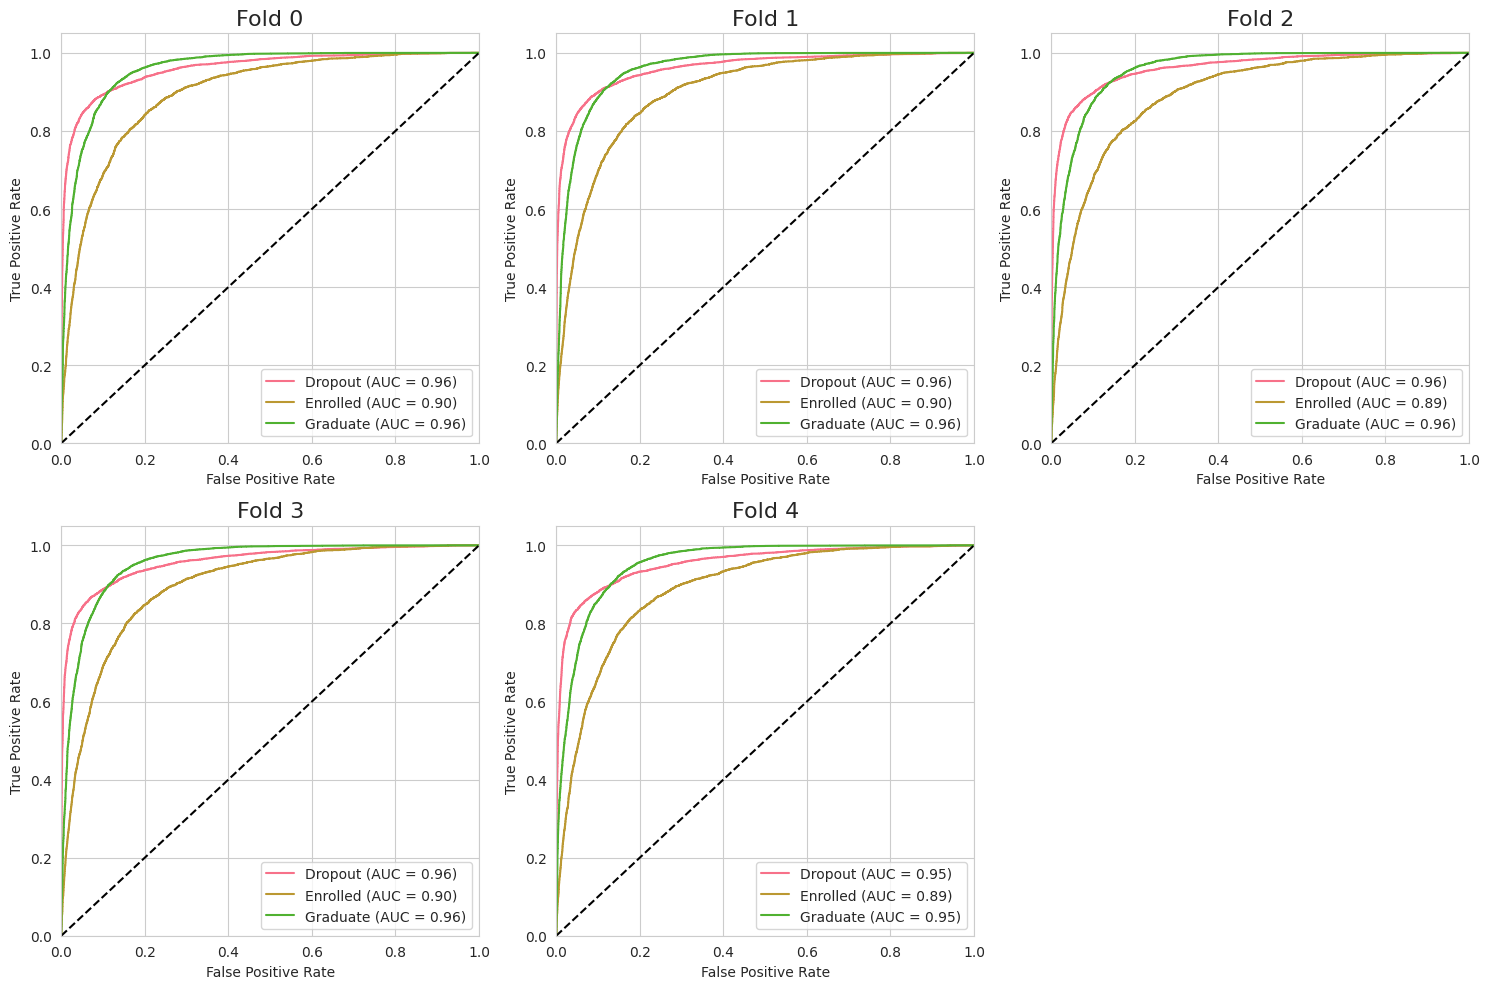

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for fold_idx, ax in enumerate(axes.flatten()):
    if f'Fold {fold_idx}' not in histories:
        fig.delaxes(ax)
        continue

    pred_probs = histories[f'Fold {fold_idx}']['pred_probs']
    preds = histories[f'Fold {fold_idx}']['preds']
    y = histories[f'Fold {fold_idx}']['y']

    preds = np.array([mappings[p] for p in preds])
    y = np.array([mappings[p] for p in y])

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(pred_probs.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y == i, pred_probs.values[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(pred_probs.shape[1]):
        ax.plot(fpr[i], tpr[i], label=f'{reverse_mappings[i]} (AUC = {roc_auc[i]:.2f})')

    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Fold {fold_idx}', fontsize=16)
    ax.legend()

plt.tight_layout()
plt.show()

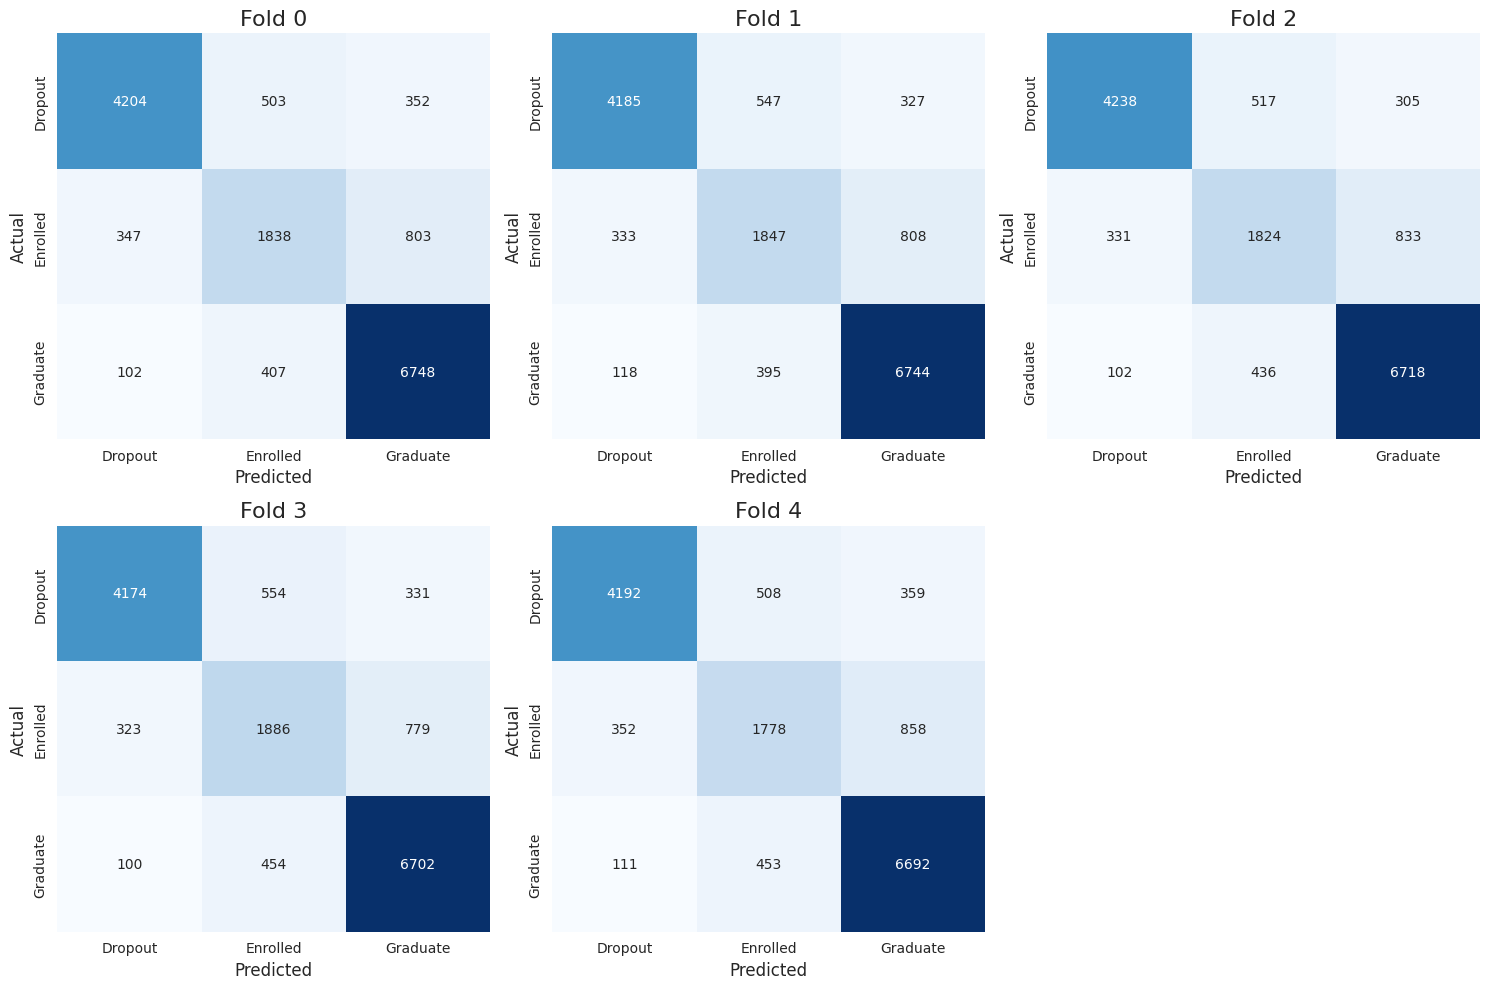

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for fold_idx, ax in enumerate(axes.flatten()):
    if f'Fold {fold_idx}' not in histories:
        fig.delaxes(ax)
        continue

    preds = histories[f'Fold {fold_idx}']['preds']
    y = histories[f'Fold {fold_idx}']['y']

    preds = np.array([mappings[p] for p in preds])
    y = np.array([mappings[p] for p in y])

    cm = confusion_matrix(y, preds)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        ax=ax,
        cmap='Blues',
        cbar=False,
        xticklabels=reverse_mappings.values(),
        yticklabels=reverse_mappings.values()
    )

    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_title(f'Fold {fold_idx}', fontsize=16)

plt.tight_layout()
plt.show()

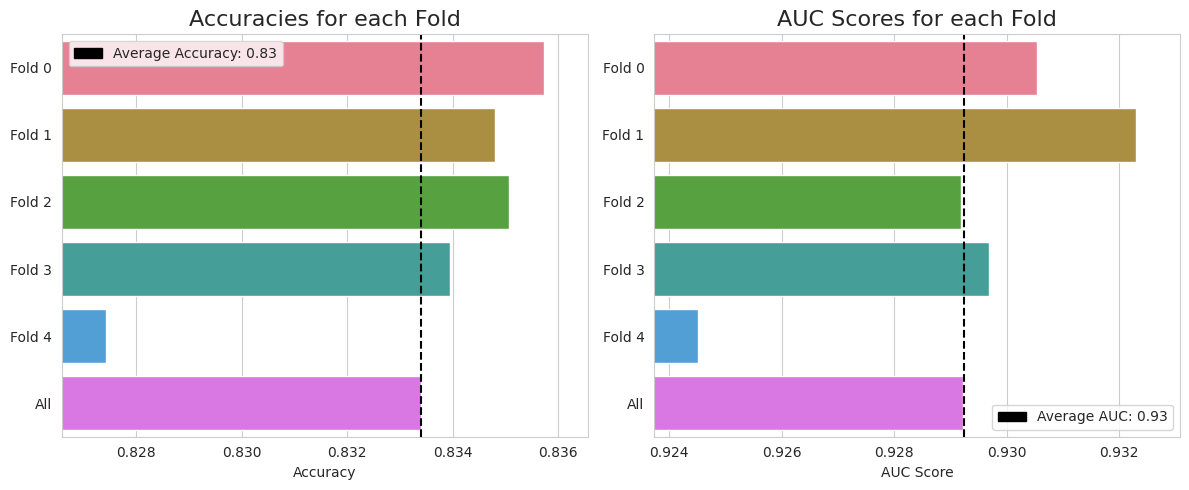

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

accuracies = [histories[f'Fold {i}']['accuracy'] for i in range(N_FOLDS)]
mean_accuracy = np.mean(accuracies)
accuracies = accuracies + [histories['All']['accuracy']]

min_acc = min(accuracies)
max_acc = max(accuracies)
acc_padding = (max_acc - min_acc) * 0.1
acc_lower_limit = min_acc - acc_padding
acc_upper_limit = max_acc + acc_padding

sns.barplot(y=[f'Fold {i}' for i in range(N_FOLDS)] + ['All'], x=accuracies, ax=axs[0], palette='husl', orient='h')
axs[0].axvline(mean_accuracy, color='black', linestyle='--')
axs[0].set_xlim(left=acc_lower_limit, right=acc_upper_limit)
axs[0].set_xlabel('Accuracy')
axs[0].set_title('Accuracies for each Fold', fontsize=16)
blue_patch = mpatches.Patch(color='black', label=f'Average Accuracy: {mean_accuracy:.2f}')
axs[0].legend(handles=[blue_patch], loc='best')


auc_scores = [histories[f'Fold {i}']['auc'] for i in range(N_FOLDS)]
mean_auc = np.mean(auc_scores)
auc_scores = auc_scores + [histories['All']['auc']]

min_auc = min(auc_scores)
max_auc = max(auc_scores)
auc_padding = (max_auc - min_auc) * 0.1
auc_lower_limit = min_auc - auc_padding
auc_upper_limit = max_auc + auc_padding

sns.barplot(y=[f'Fold {i}' for i in range(N_FOLDS)] + ['All'], x=auc_scores, ax=axs[1], palette='husl', orient='h')
axs[1].axvline(mean_auc, color='black', linestyle='--')
axs[1].set_xlim(left=auc_lower_limit, right=auc_upper_limit)
axs[1].set_xlabel('AUC Score')
axs[1].set_title('AUC Scores for each Fold', fontsize=16)
blue_patch = mpatches.Patch(color='black', label=f'Average AUC: {mean_auc:.2f}')
axs[1].legend(handles=[blue_patch], loc='best')

plt.tight_layout()
plt.show()

# Post-Processing and Inference

In [25]:
oof_files = glob.glob('test_pred_probs/fold_*_test_pred_probs_*.csv')
submissions = [pd.read_csv(f, index_col='id') for f in oof_files]

submission = pd.concat(submissions, axis=1)
submission = submission.groupby(level=0, axis=1).mean()

with open('ag_test_pred_probs.pkl', 'wb') as f:
    pickle.dump(submission.values, f)

submission['Target'] = submission.idxmax(axis=1)
submission['id'] = submission.index
submission = submission[['id', 'Target']]

submission.to_csv(f'ag_acc-{mean_accuracy:.6f}_auc-{mean_auc:.6f}.csv', index=False)
submission.head()

,id,Target
id,,
76518,76518,Dropout
76519,76519,Graduate
76520,76520,Graduate
76521,76521,Graduate
76522,76522,Enrolled
